In [1]:
import grama as gr
import numpy as np
import pandas as pd
import seaborn as sb

from scipy.optimize import bisect

# Problem Statement:

It is well-known that the electronics industry is pushing towards products with greater densities- from a consumer's perspective, more features packed in a thinner model, and from an engineer's perspective, more transistors in a smaller space.

Moore's law predicts that by the year 2020, we will have ~5nm transistors on dense integrated circuits. While this is exciting news for computer hardware, one major concern is how to cool these incredibly dense systems so that they remain within operable conditions.

One of the most common ways of cool electronic components is to stick a heat sink to the component and apply a forced flow.

To simplify the problem for current discussions, let us assume that our system has achieved steady state, and that the whole surface of the heat sink is exposed an average heat transfer coefficient, $\bar{h}$.

Mathematically, the problem is given by:

<center>$Q = \bar{h}A\Delta T$</center>

Q: Heat produced by the electronic component.\
h: Average heat transfer coefficient between the heat sink and air.\
A: Surface area of the heat sink exposed to air\
$\Delta T$: Temperature difference between the heat sink and the ambient air.

After some gross over-simplifications, we can assume that the heat sink is at the same temperature as the electronic component. Let that temperature be T.

From the specifications provided by the component manufacturer, the temperature of the component should not exceed $333.15K$. Further, from experimentation, it is determined that $Q \sim N(40,4) mW$, and $\bar{h} \sim N(10,2) W/m^2K$ based on varying enviromental conditions. Ambient temperature is known to be $298.15K$, i.e. $T_{amb} = 298.15K$. The designer's objective is to find the heat sink area $A$, such that the device has 99% reliability. 

The deterministic way to solve the above problem would be to solve for $A$, assuming $\Delta T = T_{max} - T_{amb}$.

In [2]:
Q = 4.0e-2
h = 10.0
T_amb = 298.15
T_max = 333.15
A_req = Q/h/(T_max-T_amb)
print(A_req*1e4, "cm\N{SUPERSCRIPT TWO}")

1.1428571428571428 cm²


At nominal conditions, the area of the heat sink is $\approx1.1429cm^2$. To help us understand if a design is safe or not, let us introduce a limit state function. This function provides a positive value if the design is safe, and a negative value if it isn't.

In [3]:
def limit_state_function(Q,h,A,T_amb,T_max):
    return T_max - (Q/h/A + T_amb)

In [4]:
limit_state_function(Q,h,A_req,T_amb,T_max)

0.0

The above makes it clear that even for nominal conditions, the above design is just safe. Any deviation from the nominal condition on the worse side could lead to a failure.

To allow for a safer design, engineers generally design for the worst case scenario, or include a factor of safety. Let us explore these two approaches.

## 1. Worst Case Scenario
The worst case scenario approach is when you assume the inpu parameters are all against you, thus creating the worst case for your design. The underlying assumption here is that if the design can survive the worst case, it can survive under normal operating conditions.

In the above scenario, since our input parameters are unbounded, we are unable to select a true worst case. But let us, for example, design for 3 standard deviations away from the mean. Thus,

<center>$Q = 52 mW$</center>
<center>$h = 4 W/m^2K$</center>

In [5]:
Q = 5.2e-2
h = 4.0
A1 = Q/h/(T_max-T_amb)
print("A:", A1*1e4, "cm\N{SUPERSCRIPT TWO}")

A: 3.7142857142857144 cm²


In [6]:
limit_state_function(4.0e-2,10,A1,T_amb,T_max)

24.230769230769226

While this makes the design extremely safe, it fails to offer us high product density (the area is more than tripled as compared to the nominal case).

## 2. Factor of Safety Approach

Looking at the problem from a factor of safety approach, we can define a factor of safety on top of the nominal conditions so as to make our designs safe. Let us assume this factor of safety is 1.5 on the heat generated (or 50% higher than the nominal condition).

In [7]:
Q = 1.5 * 4.0e-2
h = 10.0
A2 = Q/h/(T_max-T_amb)
print("A:", A2*1e4, "cm\N{SUPERSCRIPT TWO}")

A: 1.7142857142857142 cm²


In [8]:
limit_state_function(4.0e-2,10,A2,T_amb,T_max)

11.666666666666686

While the above is a better design than the worst-case scenario approach, it is still extremely safe$^1$.

1: While the design is exmtremely safe for the above conditions through the factor of safety approach, it might not be the case always. The factor of safety approach would be most effective once the designer is fully aware of the variations in the input parameters.

## Introducing py_grama

This above approaches for design can be swiftly captured using a new module called "py_grama", developed by Zachary del Rosario.

In [9]:
def limit_state_function(x):
    Q, h, A = x
    return T_max - (Q/h/A + T_amb)

In [10]:
md = gr.Model() >> \
    gr.cp_function(
        fun = limit_state_function,
        var = ["Q", "h", "A"],
        out = ["g_t_max"]
    ) >> \
    gr.cp_bounds(
        Q = (2.8e-2, 5.2e-2),
        h = (4, 16),
        A = (1e-5, 1e-3),
    )
md.printpretty()

model: None

  inputs:
    var_det:
      h: [4, 16]
      Q: [0.028, 0.052]
      A: [1e-05, 0.001]
    var_rand:
    copula:
        None
  functions:
    limit_state_function: ['Q', 'h', 'A'] -> ['g_t_max']


In [11]:
df_data = pd.DataFrame(dict(Q = [4.0e-2] * 2, h = [10.0] * 2, A=[A1,A2]))

gr.eval_df(md, df = df_data)

,Q,h,A,g_t_max
0,0.04,10.0,0.000371,24.230769
1,0.04,10.0,0.000171,11.666667


We can also find an optimum area for the design given the nominal conditions as inputs.

Note: If $Q$ and $\bar{h}$ are modified according to the design approach (Worst Case Scenario, or Factor of Safety), the correct optimum value for area is obtained for that approach.

In [12]:
def opt_det(A):
    df_data2 = gr.eval_df(md, df=pd.DataFrame(dict(Q = [4e-2], h = [10], A=[A])))
    return df_data2["g_t_max"].values[0]

A_opt = bisect(opt_det, 1e-5, 1e-3)
print("A_opt:", A_opt*1e4, "cm\N{SUPERSCRIPT TWO}")

A_opt: 1.1428571326658128 cm²


# End of Deterministic Modelling

As designers, it is upto us to make a design as dense as possible while maximizing reliablility. This is where Reliability Based Design Optimization (RBDO) comes in. RBDO is the process of optimizing design parameter(s) through an optimization procedure while ensuring that the reliability is above a certain threshold.

# Start of Design Under Uncertainty

Let us start by using our previously defined deterministic model and make some changes to it to reflect the uncertainty in the problem.

In [13]:
md_uncertain = \
    md >> \
    gr.cp_marginals(
        Q = dict(dist="norm", loc=4e-2, scale=4e-3),
        h = dict(dist="norm", loc=10, scale=2)
    ) >> \
    gr.cp_copula_independence() # Found in comp_building.py, not mentioned in docs.
    
md_uncertain.printpretty()

model: None

  inputs:
    var_det:
      A: [1e-05, 0.001]
    var_rand:
      Q: (+0) norm, {'loc': 0.04, 'scale': 0.004}
      h: (+0) norm, {'loc': 10, 'scale': 2}
    copula:
        Independence copula
  functions:
    limit_state_function: ['Q', 'h', 'A'] -> ['g_t_max']


Now, we have included the uncertainty of our input parameters in our model. Let us now conduct a Monte-Carlo simulation for the optimum design obtained above.

eval_monte_carlo() is rounding n...


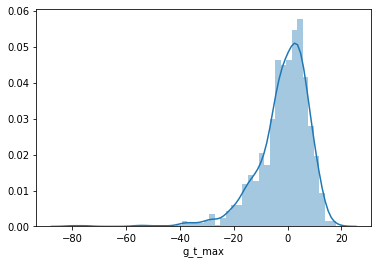

In [14]:
df_res = \
    md_uncertain >> \
    gr.ev_monte_carlo(n=1e3, df_det=pd.DataFrame(dict(A=[A_opt])), seed=26) 
sb.distplot(df_res["g_t_max"])

While about half the designs created using the above technique are safe, the other half fail. This is not a good design. We can test this out for the other two methods also.

### Worst Case Scenario Approach

eval_monte_carlo() is rounding n...


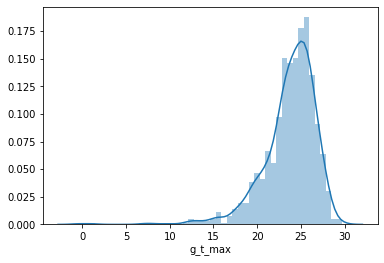

In [15]:
df_res = \
    md_uncertain >> \
    gr.ev_monte_carlo(n=1e3, df_det=pd.DataFrame(dict(A=[A1])), seed=26) 
sb.distplot(df_res["g_t_max"])

### Factor of Safety Approach

eval_monte_carlo() is rounding n...


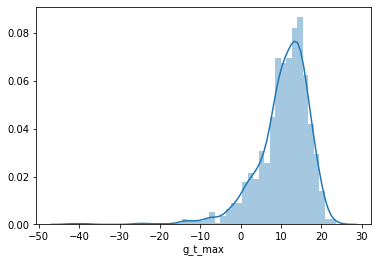

In [16]:
df_res = \
    md_uncertain >> \
    gr.ev_monte_carlo(n=1e3, df_det=pd.DataFrame(dict(A=[A2])), seed=26) 
sb.distplot(df_res["g_t_max"])

The Worst Case Scenario Approach produces extremely conservative designs, something that is undesirable in the age of high density products. The Factor of Safety Approach does not provide the desired reliability for the product. By choosing a higher Factor of Safety, we could create a better desigm.

Regardless, we can otpimize the design to have high reliability (99%) while keeping area to a minimum.

In [17]:
def opt_duu(A):
    df_mc = \
        md_uncertain >> \
        gr.ev_monte_carlo(n=500, df_det=pd.DataFrame({"A": [A]}), seed=5)
    return np.quantile(df_mc["g_t_max"], 1e-2)

A_duu = bisect(opt_duu, 1e-5, 1e-3)
print("A_duu:", A_duu*1e4, "cm\N{SUPERSCRIPT TWO}")

A_duu: 1.9679342741146684 cm²


The optimized value for area is $\approx1.9680cm^2$. Testing this out on a Monte-Carlo simulation reveals that almost all designs (99%) lie within the safe limit, while also ensuring that the design is as dense as possible.

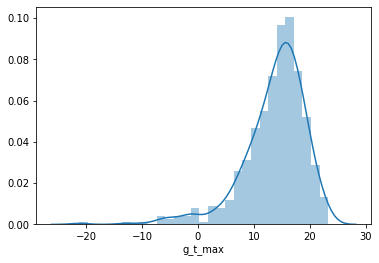

In [18]:
df_res_duu = \
    md_uncertain >> \
    gr.ev_monte_carlo(n=500, df_det=pd.DataFrame({"A": [A_duu]}), seed=101)

sb.distplot(df_res_duu["g_t_max"])